In [ ]:
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import dates as md
from scipy.stats import pearsonr

In [ ]:
PROJPATH = Path().resolve().parent
breakupdata = PROJPATH / "data/breakupdata/derived"
stationdata = PROJPATH / "data/weatherstations/ACIS/TDD/tdd_cumul_bystation"
outpath = PROJPATH / "data/breakupdata/working"

### Helper functions

In [ ]:
def datestr2dayssince(datestr: str, since: str = '0301') -> int:
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days

In [ ]:
def dayssince2date(days: int, year: int, since: str = '0301') -> dt.date:
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days))

In [ ]:
type(dayssince2date(24, 2000))

datetime.date

### Load data

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup 

,id,siteID,year,breakup
0,7175,Koyukuk River at Bettles,2022,2022-05-05
1,7173,Kobuk River at Shungnak,2022,2022-05-20
2,7172,Buckland River at Buckland,2022,2022-05-21
3,7171,Yukon River at Mountain Village,2022,2022-05-10
4,7170,Yukon River at Marshall,2022,2022-05-15
...,...,...,...,...
1490,213,Buckland River at Buckland,1988,1988-05-05
1491,212,Buckland River at Buckland,1987,1987-05-22
1492,211,Buckland River at Buckland,1986,1986-05-30
1493,210,Buckland River at Buckland,1984,1984-05-23


In [ ]:
climatologies = pd.read_csv(PROJPATH / "data/weatherstations/ACIS/TDD/all_cumul_clim1991_2020.csv", header=3, index_col=0)
climatologies

,GULKANA_AIRPORT,TANANA_AIRPORT,KETCHIKAN_AIRPORT,COLLEGE_OBSERVATORY,AUKE_BAY,BETHEL_AIRPORT,ANCHORAGE_MERRILL_FIELD,SKAGWAY_AIRPORT,EAGLE,BIG_DELTA_AIRPORT,...,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,YAKUTAT_AIRPORT,ALYESKA,NENANA_MUN_AP,HOMER_AIRPORT,NORTHWAY_AIRPORT,CHICKEN,FAIRBANKS_INTL_AP,DUTCH_HARBOR,MCKINLEY_PARK
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,4.30,0.00,0.10,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.86,0.00
1,0.00,0.00,8.65,0.00,0.24,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.21,0.00
2,0.00,0.00,13.33,0.00,0.24,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.46,0.00
3,0.00,0.00,15.84,0.00,0.24,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.73,0.00
4,0.00,0.00,18.42,0.00,0.24,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1089.80,1197.70,1656.02,1312.75,1540.05,924.30,1402.03,1532.79,1209.40,1291.97,...,1287.18,1120.21,1164.24,1327.39,1080.11,1146.83,949.87,1421.01,908.20,925.74
118,1114.59,1225.56,1681.10,1341.58,1565.31,946.68,1429.66,1559.27,1237.86,1319.18,...,1313.30,1141.43,1188.43,1355.51,1101.23,1173.10,972.87,1451.41,924.52,949.08
119,1139.42,1254.35,1706.48,1370.45,1591.26,969.11,1457.16,1584.69,1266.97,1347.30,...,1339.78,1163.26,1212.25,1383.96,1123.23,1200.33,995.61,1482.66,941.57,971.67


In [ ]:
tdd = sorted(list(stationdata.glob("*.csv")))

In [ ]:
def retrieve_tdd(row, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march-offset][str(row.year)]
    except KeyError:
        return np.nan

def retrieve_tdd_anomaly(row, stationname, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march1-offset][str(row.year)] - climatologies[stationname].iloc[row.days_since_march1-offset]
    except KeyError:
        return np.nan
    
def retrieve_tdd_anomaly_fixed(row, stationname, stationDF, datestring):
    """Datestring is something like 04-15"""
    days_since_march1 = datestr2dayssince(f"{str(row.year)}-{datestring}")
    try:
        return stationDF.iloc[days_since_march1][str(row.year)] - climatologies[stationname].iloc[days_since_march1]
    except KeyError:
        return np.nan

## Model breakup by TDD anomaly for all locations

Load breakup data again and recalculate anomaly dataframe.

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup_anomaly = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_tdd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
breakup_anomaly

,id,siteID,year,breakup,days_since_march1,ALYESKA,ANCHORAGE_MERRILL_FIELD,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,AUKE_BAY,BARROW_AIRPORT,...,NENANA_MUN_AP,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SAINT_PAUL_ISLAND_AIRPORT,SITKA_AIRPORT,SKAGWAY_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT,YAKUTAT_AIRPORT
0,7175,Koyukuk River at Bettles,2022,2022-05-05,65,88.98,56.74,73.36,11.13,0.0,...,17.44,73.50,-11.65,3.04,41.92,87.62,42.66,35.14,62.05,52.13
1,7173,Kobuk River at Shungnak,2022,2022-05-20,80,82.83,56.59,91.24,-26.59,0.0,...,-43.24,58.86,-72.74,-71.26,47.17,84.85,20.70,15.90,3.74,14.97
2,7172,Buckland River at Buckland,2022,2022-05-21,81,88.03,61.16,96.16,-23.14,0.0,...,-38.34,76.78,-69.29,-65.65,48.51,89.27,21.64,18.70,5.65,14.87
3,7171,Yukon River at Mountain Village,2022,2022-05-10,70,92.97,63.78,83.34,2.23,0.0,...,-6.91,65.26,-34.56,-25.43,48.23,77.72,34.46,22.17,40.86,39.37
4,7170,Yukon River at Marshall,2022,2022-05-15,75,74.42,44.00,70.25,-18.28,0.0,...,-41.96,56.49,-62.56,-65.31,54.82,75.28,20.76,3.21,6.32,20.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,213,Buckland River at Buckland,1988,1988-05-05,65,-0.02,NaN,20.86,134.29,0.0,...,NaN,64.00,33.35,124.54,4.42,23.12,99.16,16.14,125.05,85.13
1491,212,Buckland River at Buckland,1987,1987-05-22,82,27.99,NaN,72.01,40.12,0.0,...,NaN,36.76,-50.44,27.53,86.53,56.39,NaN,11.77,27.98,62.59
1492,211,Buckland River at Buckland,1986,1986-05-30,90,-99.76,NaN,-108.34,-97.28,0.0,...,NaN,-87.49,-178.51,-180.04,14.62,-137.49,-58.79,-103.17,-108.11,-62.37
1493,210,Buckland River at Buckland,1984,1984-05-23,83,36.22,NaN,244.94,273.34,0.0,...,-100.39,41.39,4.44,-53.01,-31.73,214.47,235.62,30.17,-81.23,147.49


In [ ]:
locations = breakup.siteID.unique()
locations

array(['Koyukuk River at Bettles', 'Kobuk River at Shungnak',
       'Buckland River at Buckland', 'Yukon River at Mountain Village',
       'Yukon River at Marshall', 'Yukon River at Russian Mission',
       'Yukon River at Holy Cross', 'Kobuk River at Ambler',
       'Yukon River at Anvik', 'Kobuk River at Kobuk',
       'Gulkana River nr Gakona', 'Yukon River at Alakanuk',
       'Yukon River nr Emmonak', 'Yukon River at Kaltag',
       'Yukon River at Galena', 'Yukon River at Fort Yukon',
       'Kuskokwim River at Tuluksak', 'Kuskokwim River at Kalskag',
       'Kuskokwim River at Crooked Creek', 'Kuskokwim River at Red Devil',
       'Kuskokwim River at Sleetmute', 'Kuskokwim River at Akiak',
       'Yukon River at Ruby', 'Kuskokwim River at McGrath',
       'Yentna River at Lake Creek', 'Yukon River at Tanana',
       'Koyukuk River at Hughes', 'Koyukuk River at Allakaket',
       'Yukon River at Circle', 'Susitna River at Sunshine',
       'Yukon River at Dawson', 'Yukon River 

In [ ]:
breakup_anomaly

,id,siteID,year,breakup,days_since_march1,ALYESKA,ANCHORAGE_MERRILL_FIELD,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,AUKE_BAY,BARROW_AIRPORT,...,NENANA_MUN_AP,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SAINT_PAUL_ISLAND_AIRPORT,SITKA_AIRPORT,SKAGWAY_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT,YAKUTAT_AIRPORT
0,7175,Koyukuk River at Bettles,2022,2022-05-05,65,88.98,56.74,73.36,11.13,0.0,...,17.44,73.50,-11.65,3.04,41.92,87.62,42.66,35.14,62.05,52.13
1,7173,Kobuk River at Shungnak,2022,2022-05-20,80,82.83,56.59,91.24,-26.59,0.0,...,-43.24,58.86,-72.74,-71.26,47.17,84.85,20.70,15.90,3.74,14.97
2,7172,Buckland River at Buckland,2022,2022-05-21,81,88.03,61.16,96.16,-23.14,0.0,...,-38.34,76.78,-69.29,-65.65,48.51,89.27,21.64,18.70,5.65,14.87
3,7171,Yukon River at Mountain Village,2022,2022-05-10,70,92.97,63.78,83.34,2.23,0.0,...,-6.91,65.26,-34.56,-25.43,48.23,77.72,34.46,22.17,40.86,39.37
4,7170,Yukon River at Marshall,2022,2022-05-15,75,74.42,44.00,70.25,-18.28,0.0,...,-41.96,56.49,-62.56,-65.31,54.82,75.28,20.76,3.21,6.32,20.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,213,Buckland River at Buckland,1988,1988-05-05,65,-0.02,NaN,20.86,134.29,0.0,...,NaN,64.00,33.35,124.54,4.42,23.12,99.16,16.14,125.05,85.13
1491,212,Buckland River at Buckland,1987,1987-05-22,82,27.99,NaN,72.01,40.12,0.0,...,NaN,36.76,-50.44,27.53,86.53,56.39,NaN,11.77,27.98,62.59
1492,211,Buckland River at Buckland,1986,1986-05-30,90,-99.76,NaN,-108.34,-97.28,0.0,...,NaN,-87.49,-178.51,-180.04,14.62,-137.49,-58.79,-103.17,-108.11,-62.37
1493,210,Buckland River at Buckland,1984,1984-05-23,83,36.22,NaN,244.94,273.34,0.0,...,-100.39,41.39,4.44,-53.01,-31.73,214.47,235.62,30.17,-81.23,147.49


In [ ]:
selected_location = 'Yukon River at Russian Mission'
selected_short = 'Russian Mission'

In [ ]:
eagle_mean = dt.datetime(2000, 3, 1) + dt.timedelta(days=breakup_anomaly[breakup_anomaly['siteID'] == selected_location].days_since_march1.mean())
eagle_std = breakup_anomaly[breakup_anomaly['siteID'] == selected_location].days_since_march1.std()
eagle_mean_plus = eagle_mean + dt.timedelta(days=eagle_std)
eagle_mean_minus = eagle_mean - dt.timedelta(days=eagle_std)

In [ ]:
def calculate_corr(breakupDF=breakup_anomaly, show_plots=False, save_plots=False, 
               prefix="TDD_breakupday", locations=locations, stationnames=None):
    if not set(locations) <= set(breakupDF.siteID):
        raise Exception("Sorry, the location isn't available in the breakup dataset. Check spelling?")
    outputrecords = []
    for location in locations:
        testDF = breakupDF[breakupDF.siteID == location].sort_values(
            by='year').reset_index(drop=True)
        if stationnames is None:
            stationnames = testDF.columns[5:]
        if not set(stationnames) <= set(breakupDF.columns):
            raise Exception("Sorry, the station isn't a valid name")
        for stationname in stationnames:
            result = testDF[stationname].corr(testDF['days_since_march1'],
                        method=lambda x, y: pearsonr(x, y))
            outputrecords.append(
                {
                    "stationname": stationname,
                    "location": location,
                    "pvalue": result.pvalue,
                    "rvalue": result.statistic,
                    "r2value": result.statistic**2
                }
            )
            if show_plots or save_plots:
                sb.regplot(data=testDF, y='days_since_march1', x=stationname, scatter=False)
                ax = sb.scatterplot(data=testDF, y='days_since_march1', x=stationname, 
                                    hue='year', palette="crest")
                ax.set_title(f"{stationname.replace('_', ' ').title()} station for {location} "
                             f"{prefix.replace('_', ' ')}")
                ax.set_xlabel("TDD anomaly")
                ax.set_ylabel("Days since March 1")
                plt.legend(loc='upper right')
                ax.text(0.06, 0.1, 
                        f'r = {result.statistic:.2f}\nr2 = {result.statistic**2:.2f}\np = {result.pvalue:.2E}', 
                        transform=ax.transAxes)
                if show_plots:
                    plt.show()
                if save_plots:
                    fn = f"{prefix}_{location.replace(' ', '_')}_AT_{stationname}.png"
                    plt.savefig(outpath / fn, bbox_inches='tight')
                    plt.close()
    return outputrecords

Eagle only, all dates

In [ ]:
datestr = "04-15"
textstr = "April 15"
fnstr = textstr.replace(" ", "")

In [ ]:
output = {}

for ii in range(10):
    datepoint = dt.datetime(2000, 4, 20) + dt.timedelta(days=ii)
    datestr = datepoint.strftime('%m-%d')
    breakup_anomaly_fixed = breakup.copy()

    for pth in tdd:
        stationname = pth.stem[:-17]
        teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
        breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
            lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed)
    output[datestr] = returnrec

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/pyth

In [ ]:
output = {}

for ii in range(65):
    datepoint = dt.datetime(2000, 4, 1) + dt.timedelta(days=ii)
    datestr = datepoint.strftime('%m-%d')
    breakup_anomaly_fixed = breakup.copy()

    for pth in tdd:
        stationname = pth.stem[:-17]
        teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
        breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
            lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed, locations=[selected_location])
    output[datestr] = returnrec
    


/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/chris/mambaforge/envs/fiweps/lib/pyth

In [ ]:
output

{'04-20': [{'stationname': 'ALYESKA',
   'location': 'Koyukuk River at Bettles',
   'pvalue': 0.15338426286705986,
   'rvalue': -0.23619856179655138,
   'r2value': 0.055789760594759305},
  {'stationname': 'ANCHORAGE_MERRILL_FIELD',
   'location': 'Koyukuk River at Bettles',
   'pvalue': 0.3736338346028459,
   'rvalue': -0.18589650796326673,
   'r2value': 0.03455751167293689},
  {'stationname': 'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT',
   'location': 'Koyukuk River at Bettles',
   'pvalue': 0.31945769868392726,
   'rvalue': -0.15941511145100104,
   'r2value': 0.025413177758935084},
  {'stationname': 'AUKE_BAY',
   'location': 'Koyukuk River at Bettles',
   'pvalue': 0.8861528387548641,
   'rvalue': 0.02337596064033884,
   'r2value': 0.0005464355358586705},
  {'stationname': 'BARROW_AIRPORT',
   'location': 'Koyukuk River at Bettles',
   'pvalue': nan,
   'rvalue': nan,
   'r2value': nan},
  {'stationname': 'BETHEL_AIRPORT',
   'location': 'Koyukuk River at Bettles',
   'pvalue': 0.

In [ ]:
eagle_correlationseriesDF = pd.DataFrame.from_records([
    {'date': item, 'stationname': subitem['stationname'], 
     'location': subitem['location'], 'r2': subitem['r2value']} 
    for item in output for subitem in output[item]])
eagle_correlationseriesDF.fillna(0, inplace=True)
eagle_correlationseriesDF['dummydate'] = '2000-'+ eagle_correlationseriesDF['date']
eagle_correlationseriesDF['DateStamp'] = pd.to_datetime(eagle_correlationseriesDF['dummydate'], format='%Y-%m-%d')
eagle_correlationseriesDF.drop(columns=['dummydate'], inplace=True)
eagle_correlationseriesDF['stationname'] = eagle_correlationseriesDF['stationname'].str.replace('AIRPORT', 'AP')
eagle_correlationseriesDF['stationname'] = eagle_correlationseriesDF['stationname'].str.replace('INTERNATIONAL', 'INTL')
eagle_correlationseriesDF

,date,stationname,location,r2,DateStamp
0,04-20,ALYESKA,Koyukuk River at Bettles,0.055790,2000-04-20
1,04-20,ANCHORAGE_MERRILL_FIELD,Koyukuk River at Bettles,0.034558,2000-04-20
2,04-20,ANCHORAGE_TED_STEVENS_INTL_AP,Koyukuk River at Bettles,0.025413,2000-04-20
3,04-20,AUKE_BAY,Koyukuk River at Bettles,0.000546,2000-04-20
4,04-20,BARROW_AP,Koyukuk River at Bettles,0.000000,2000-04-20
...,...,...,...,...,...
15165,04-29,SITKA_AP,Gakona River at Gakona,0.182791,2000-04-29
15166,04-29,SKAGWAY_AP,Gakona River at Gakona,0.202426,2000-04-29
15167,04-29,TALKEETNA_AP,Gakona River at Gakona,0.441606,2000-04-29
15168,04-29,TANANA_AP,Gakona River at Gakona,0.150156,2000-04-29


In [ ]:
sb.set_style('darkgrid')
sb.set_context('talk', font_scale=1)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabels'

<Figure size 640x480 with 0 Axes>

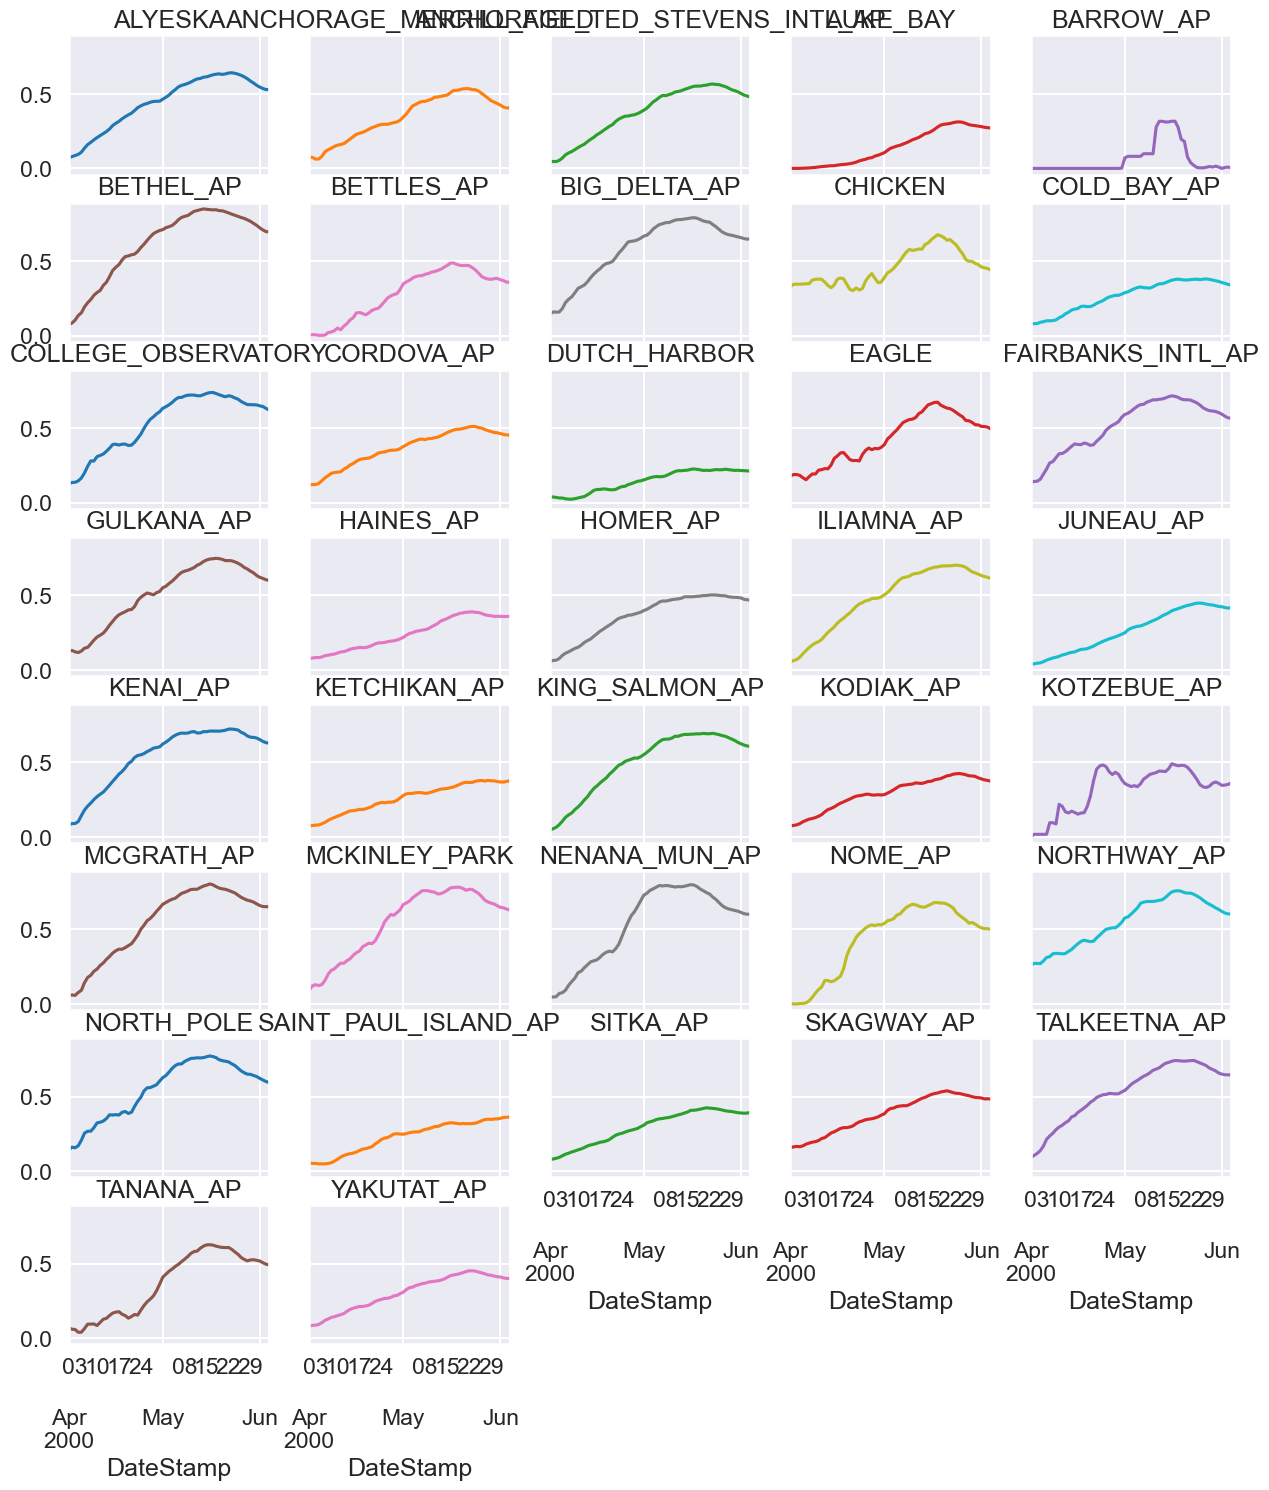

In [ ]:
fig = plt.figure()
eagle_correlationseriesDF.drop(
    columns=['date', 'dummydate']).pivot(
        index='DateStamp', columns='stationname', 
        values='r2').plot(
            subplots=True, layout=(8,5), figsize=(15, 17),
            sharey=True, ylabel='', title=list(eagle_correlationseriesDF.stationname.unique()), legend=False)
plt.set_xlabels('')
fig.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)


In [ ]:
sb.set_context('poster', font_scale=1)

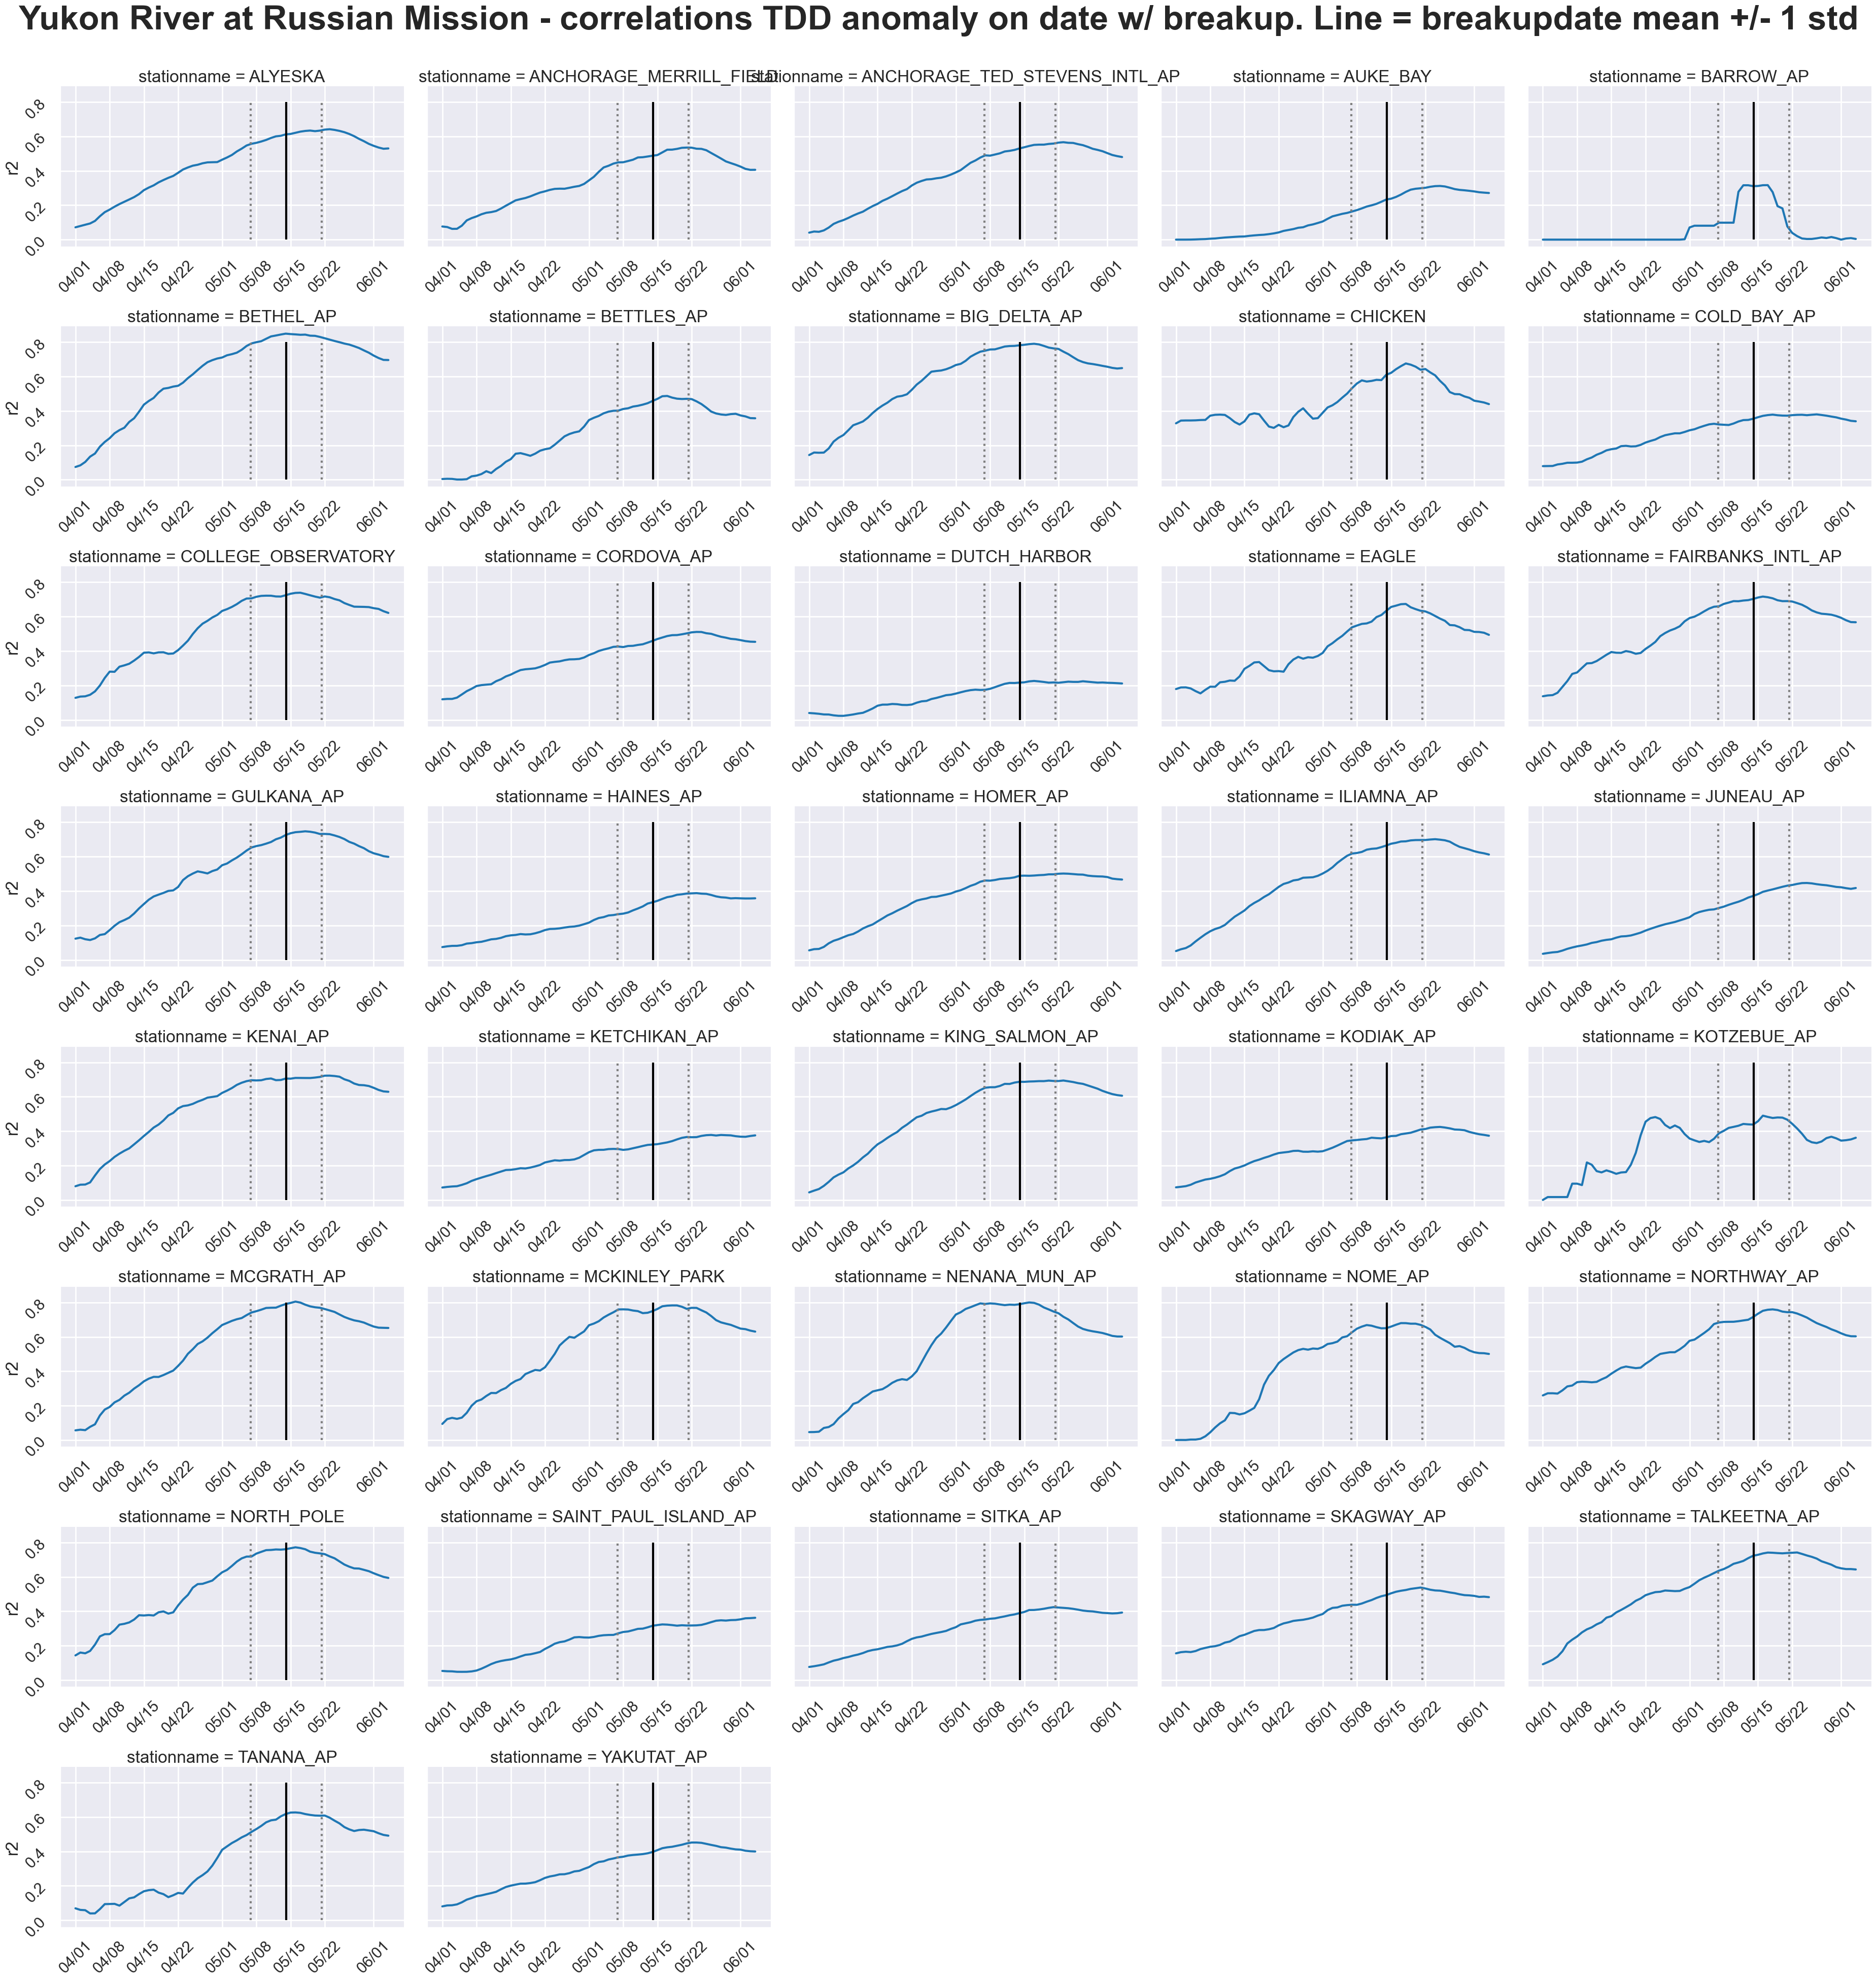

In [ ]:

g = sb.relplot(eagle_correlationseriesDF, x='DateStamp', y='r2', col='stationname', col_wrap=5, kind='line', aspect=1.5, facet_kws={'sharex': 'col'} )
xformatter = md.DateFormatter("%m/%d")
g.set_xlabels('')

# g.set_xticklabels(rotation=90)
for ax in g.axes:
    ax.tick_params(rotation=45, labelbottom=True)
    ax.xaxis.set_major_formatter(xformatter)
    ax.vlines(x=eagle_mean, ymin=0, ymax=0.8, colors='black')
    ax.vlines(x=eagle_mean_plus, ymin=0, ymax=0.8, colors='grey', linestyles='dotted')
    ax.vlines(x=eagle_mean_minus, ymin=0, ymax=0.8, colors='grey', linestyles='dotted')

g.fig.tight_layout()
g.fig.suptitle(f"{selected_location} - correlations TDD anomaly on date w/ breakup. Line = breakupdate mean +/- 1 std", fontsize=48, fontweight='bold')
g.fig.subplots_adjust(top=0.94,)



In [ ]:
for ax in g.axes:
    ax.tick_params(rotation = 90)


### Write top correlations to files